# **Classificar imagens com uso de RNNs Bidirecionais**

- CNNs, tipicamente usadas para classificação de imagens, podem ser utilizadas para a classificação de sequências de vetores de palavras.
- Da mesma forma, RNNs, tipicamente empregadas em NLP, podem ser aplicadas à classificação de imagens.
- Isto envolve algumas operações importantes em Keras, tais como **transposição e concatenação de dados**.

- Neste projeto, utilizamos RNNs bidirecionais (LSTM) para classificação de imagens.
- Os arquivos de imagens pertencem ao MNIST Dataset (Kaggle), o qual contém imagens de dígitos (os documentos txt representam cada um dos pixels da imagem no canal RGB, sendo 0 a intensidade nula, e 255 a intensidade máxima, R = Red, G = Green, B = Blue)

  https://www.kaggle.com/c/digit-recognizer

# **Arquitetura do classificador RNN**

- Pense em uma **imagem como uma sequência de pixels**.
- Imagens constituem sinais bidimensionais, enquanto áudios e textos são sinais unidimensionais (a única dimensão é o tempo ou a extensão).
- **RNNs, tais como GRUs e LSTMs, trabalham com sinais unidimensionais**, uma vez que "avançam" em uma única direção.

A imagem pode ser entendida como uma matriz T x D, na qual T = altura; e D = comprimento.
- Em uma sequência de vetores de palavras, teríamos também uma matriz T x D, na qual T = comprimento da sequência; e D = Dimensionalidade da propriedade ("feature dimensionality").
- Nesta sequência, a RNN é executada do começo (primeira palavra) para o fim (última palavra); ou então utiliza-se uma RNN bidirecional, a qual executa a RNN tanto do começo para o fim, quanto na ordem reversa, do fim em direção ao começo.

Note que a imagem também é um objeto bidimensional, o qual podemos avaliar do topo à sua base, ou da base para o seu topo.
- Assim, usamos a RNN para avaliar a imagem do topo à base; ou aplicamos uma RNN bidirecional para avaliar a imagem simultaneamente do topo para a base, e da base para o topo.
- Podemos ver as **diferentes alturas da imagem como pontos coletados em diferentes tempos; enquanto que diferentes larguras são vistas como diferentes propriedades ("features")**.

Note que, neste caso, perdemos a perspectiva da largura. Isso porque a variável escolhida para se tornar análoga ao tempo (sentido da RNN) foi a altura, enquanto que a largura passou a ser análoga a cada propriedade do vetor de palavras.

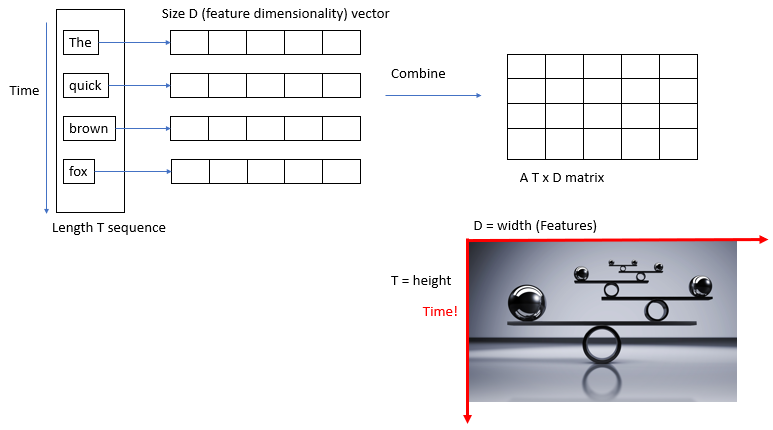

### **Se rotacionarmos a imagem em 90ᴼ e executarmos a RNN bidirecional tanto na imagem original quanto na imagem rotacionada, teremos varrido a imagem em todas as direções**:

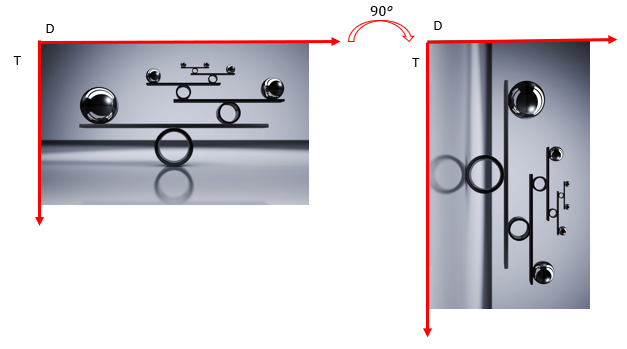

- Note que, na imagem à esquerda, estamos tratando as diferentes alturas como pontos obtidos em tempos diferentes.
- As alturas da imagem rotacionada, à direita, correspondem às larguras da imagem original. 
- Assim, na imagem à direita, tratamos as larguras da imagem original como pontos coletados em instantes diferentes.

Esta abordagem resolve o problema da perda de "perspectiva" de uma dimensão, já que analisamos a altura (com a largura usada como tempo) e a largura (com a altura usada como tempo).
- Porém, **a abordagem criou dois ramos paralelos no modelo**:

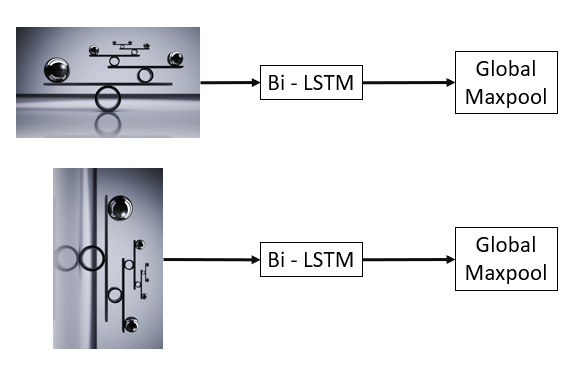

- Como de costume, utilizamos a função Global Max Pooling para capturar os hidden states mais importantes providos pelas RNNs.

### **Dada a dimensionalidade latente do LSTM = M, qual é o tamanho da saída?**

- O tamanho da saída de uma LSTM bidirecional, como visto, é 2M.
- Para um tamanho de amostra (batch size) = N, a saída do primeiro LSTM bidirecional será N x H x (2M).
- H = Height = altura = análogo à dimensão de tempo para a primeira unidade RNN.
- **A operação de Pooling opera sobre a dimensão de tempo, eliminando esta dimensão**. Como resultado, temos a saída N x (2M) no primeiro ramo (imagem original).


- Na segunda unidade LSTM bidirecional temos o cenário exatamente oposto. Como nós rotacionamos a imagem, os dados adquiriram forma N x W x H. **Agora, a RNN tratará a largura W como o tempo**.
- Assim, a saída da segunda unidade LSTM bidirecional será N x W x (2M). **Após o Max Pooling, obtemos novamente N x (2M)**.

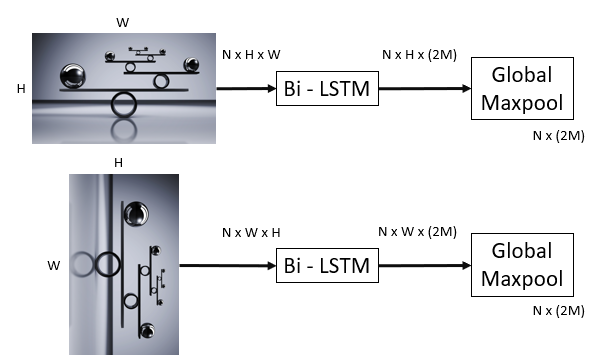

Temos agora duas saídas N x (2M). Em deep learning, **a forma típica de lidar com uma situação como esta é simplesmente concatenar as saídas**.

- A **concatenação de duas saídas M x (2M) resulta em uma saída M x (4M)**.
- Precisamos concatenar as saídas ao longo da dimensão da propriedade ("feature dimension"), pois não podemos terminar a modelagem com mais amostras do que tínhamos no início do problema.

A seguir, o processo procede como de costume:
- Passamos os dados por uma camada densa ("dense layer", completamente conectada); e
- Utilizamos a função de ativação softmax, que, conforme visto, é uma abordagem probabilística para o cálculo do valor máximo. 

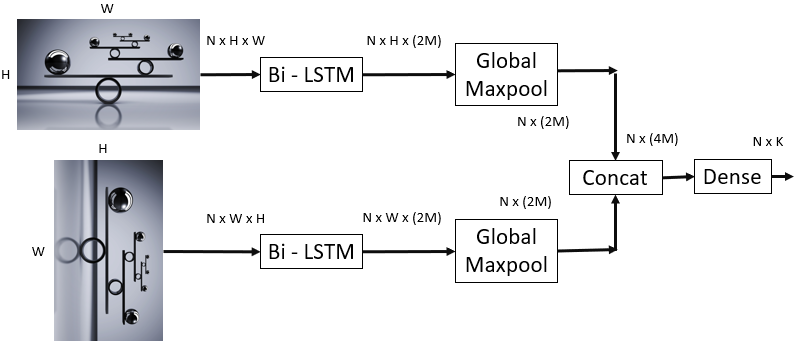

In [ ]:
#Garantir que está usando a versão mais recente de Keras
! pip install keras --upgrade

# **Roteiro para construção de modelos em Keras**

1) Carregar os dados e convertê-los a um formato adequado para a construção do modelo. **As funções do Pandas são necessárias para converter bases gravadas como CSV ou arquivo Excel em objetos do tipo dataframe**, independente se os dados forem previamente carregados no Google Drive, se foram carregados diretamente no ambiente do Google Colab, ou se foram carregados offline usando uma IDE como o Anaconda.

2) Criar o modelo: aqui, forneceremos ao Keras a estrutura do modelo, por exemplo, tipos e configurações das camadas da rede neural, bem como a sequência das camadas e operações.

3) Treinar o modelo com os dados e avaliar seus resultados.

## **Adaptação da RNN para o caso bidirecional**

Poucas mudanças são necessárias no código. Basicamente, devemos adicionar a "wrapper layer" (camada de empacotamento).

- Para isso, simplesmente substituímos:

```
LSTM (M)
```
Por:


```
Bidirectional (LSTM(M))
```
- Isto converte automaticamente a RNN em uma RNN bidirecional.

# **Quando não utilizar uma RNN bidirecional**

Embora poderosas, existem algumas situações nas quais o uso da rede bidirecional não é recomendável (**preferível utilizar a RNN convencional**):
- **RNNs bidirecionais não devem ser empregadas quando se deseja prever comportamento ou valor futuro**.

- Não há sentido em utilizar inputs que estão ainda mais distantes no futuro (os inputs da RNN reversa). Isto iria requerer dados que ainda não existem, justamente os que desejamos prever.

NOTA: Foi citado anteriormente o caso das séries temporais com dados autocorrelacionados. Neste caso, não há problemas em utilizar a rede bidirecional, pois desejamos justamente avaliar o impacto histórico e os efeitos de memória. **Para isso, precisamos avaliar a série temporal dentro de uma sequência de dados temporais finita, com começo e fim bem definidos**. 

Assim, como a avaliação de dados autocorrelacionados em séries temporais não envolve a realização de previsões futuras, mas tão somente a análise de efeitos de memória dentro de um tempo finito, as redes bidirecionais podem ser utilizadas. 

- Embora este seja um problema para análise de séries temporais com RNNs, não costuma ser uma limitação em NLP. Isso porque, em NLP, costumamos usar a sequência completa (a frase, trecho, ou texto) como input de uma só vez.

# **Fazer upload de arquivos a partir de sistema de arquivos local**

<code>files.upload</code> é um comando que retorna um dicionário Python com os arquivos incluídos no upload.
O dicionário é indexado com o nome do arquivo e os valores são os dados enviados por upload.

CONFIGURAR Ambiente do COLAB:
No menu superior, clique sobre a seta ao lado das barras RAM e Disco. No dropdown mostrado, selecione 
**"Ver recursos"**.

No novo menu, utilize a barra de rolagem até chegar ao extremo inferior, e selecione a opção **"Alterar o tipo de ambiente de execução"**.

Por fim, em **"Acelerador de hardware"**, selecione **"GPU"**.

# **Google Drive**

É possível acessar os arquivos no Drive de várias maneiras. Por exemplo:
- Montar o Google Drive na máquina virtual do ambiente de execução
- Usar um wrapper ao redor da API, <a href="https://pythonhosted.org/PyDrive/">como o PyDrive</a>
- Usar a <a href="https://developers.google.com/drive/v3/web/about-sdk">API REST nativa</a>



Veja abaixo exemplos de cada um eles.

# **Montar o Google Drive localmente - Autorizar conexão do Google Colab aos arquivos do Google Drive**

O exemplo abaixo mostra como montar o Google Drive no seu ambiente de execução usando um código de autorização, além de como gravar e ler arquivos nele. Depois de executado, você verá o novo arquivo &#40;<code>foo.txt</code>&#41; no <a href="https://drive.google.com/">https://drive.google.com/</a>.

Isto permite somente ler, gravar e mover arquivos. Para modificar de maneira programática as configurações de compartilhamento ou outros metadados, use uma das opções abaixo.

<strong>Observação:</strong> ao usar o botão "Montar Drive" no navegador de arquivos, não é necessário usar nenhum código de autenticação para notebooks que tenham sido editados somente pelo usuário atual.

In [ ]:
#Esta célula é utilizada para conectar à conta do Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


No menu à esquerda, clique sobre o ícone da pasta ("**Arquivos**"), e localize dentro da nova pasta "drive" a pasta do Google Drive contendo os arquivos desejados (clique na seta para expandir os dropdowns). 

Clique sobre a elipse (3 pontos à direita) do arquivo desejado e selecione a opção "**Copiar caminho**" para copiar os endereços de cada um dos arquivos que serão analisados.

Note que o caminho será diferente para cada usuário do Google Drive.

Endereços:

Dados de treino (train.csv): /content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 4 - Image Class. with Bidirectional RNNs/MNIST Dataset - digit-recognizer/train.csv

Dados de teste (test.csv): /content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 4 - Image Class. with Bidirectional RNNs/MNIST Dataset - digit-recognizer/test.csv

# **Importar bibliotecas para análise**

In [ ]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Bidirectional, GlobalMaxPooling1D, Lambda, Concatenate, Dense
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

### Note que **importamos o método "Concatenate"** 
- Devido à importância desta operação, já existe um método Keras pronto.

As bibliotecas "os" e "sys" possibilitam ler e fundir (merge) arquivos, como será visto adiante.

# **Construir função para capturar os dados de imagens e convertê-los a um formato adequado**

- Vamos criar uma função get_mnist, a qual carregará os dados do MNIST Dataset e:
- Escalonar ("scaling") os dados para um intervalo 0 a 1; e
- Retorná-los como um conjunto de valores numéricos.

No sistema RGB (R = red; G = green; B = blue), cada pixel é representado como uma intensidade em cada um dos canais: (Ir, Ig, Ib). Ir, Ig e Ib variam de **zero (intensidade nula) até 255 (intensidade máxima)**.
- Assim, a **normalização é realizada por meio da divisão por 255**.

In [ ]:
def get_mnist(limit=None):
  if not os.path.exists('/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 4 - Image Class. with Bidirectional RNNs/'):
    print("You must create a folder called large_files adjacent to the class folder first.")
  if not os.path.exists('/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 4 - Image Class. with Bidirectional RNNs/MNIST Dataset - digit-recognizer/train.csv'):
    print("Looks like you haven't downloaded the data or it's not in the right spot.")
    print("Please get train.csv from https://www.kaggle.com/c/digit-recognizer")
    print("and place it in the large_files folder.")

  print("Reading in and transforming data...")
  df = pd.read_csv('/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 4 - Image Class. with Bidirectional RNNs/MNIST Dataset - digit-recognizer/train.csv')
  data = df.values
  np.random.shuffle(data)
  X = data[:, 1:].reshape(-1, 28, 28) / 255.0 # data is from 0..255
  Y = data[:, 0]
  if limit is not None:
    X, Y = X[:limit], Y[:limit]
  return X, Y

# **Carregar os dados**

Vamos utilizar a função anterior para carregar os dados, tanto das imagens X quanto das respostas Y (rótulos).

In [ ]:
# get data
X, Y = get_mnist()

# config
D = 28
M = 15

# input is an image of size 28x28
input_ = Input(shape=(D, D))

Reading in and transforming data...


Todas as imagens do MNIST Dataset são de dimensões 28 x 28 pixels, de modo que podemos usar a mesma variável D para as duas dimensões de todas.
- A dimensionalidade M = 15 foi escolhida arbitrariamente: **é um hiperparâmetro que pode ser ajustado**.

Note que ainda não começamos o treinamento das RNNs. O que fizemos aqui foi carregar as imagens e seus rótulos, e definir hiperparâmetros.

# **Construção e avaliação da RNN**

# **Criação da primeira RNN bidirecional**

- Devemos fornecer o parâmetro `return_sequences=True` para que todos os hidden states sejam retornados.
- Passamos o tensor de input (dados a serem ajustados) pela unidade recursiva bidirecional LSTM e submetemos a saída a uma operação Global Max Pooling, como discutido no início do Notebook.

In [ ]:
# up-down
rnn1 = Bidirectional(LSTM(M, return_sequences=True))
x1 = rnn1(input_) # output is N x D x 2M
x1 = GlobalMaxPooling1D()(x1) # output is N x 2M

- Como discutido, o formato dos dados agora é N x (2M). Isto poderia ser checado com um experimento como os realizados nos casos de RNN e RNN bidirecional anteriores.

# **Criação da segunda RNN bidirecional**

Como discutido no início do notebook, precisamos rotacionar as imagens em 90º e, a seguir, executar uma segunda RNN bidirecional.
- Enquanto na primeira RNN tomamos a altura como o tempo, a segunda RNN tomará a largura como o tempo.
- Com a rotação, as alturas das imagens originais se tornam as larguras; e as larguras das imagens originais se tornam as alturas das novas imagens.

Para executar a rotação em 90º, basta invocarmos o método `permute_dimensions`, fornecendo a ele a nova configuração para as dimensões originais (módulo importado em: `import keras.backend as K`).

In [ ]:
# left-right
rnn2 = Bidirectional(LSTM(M, return_sequences=True))

# custom layer
permutor = Lambda(lambda t: K.permute_dimensions(t, pattern=(0, 2, 1)))

x2 = permutor(input_)
x2 = rnn2(x2) # output is N x D x 2M
x2 = GlobalMaxPooling1D()(x2) # output is N x 2M

Note que não podemos invocar diretamente o método.

A solução, em Keras, **é transformar a função de permuta das dimensões em uma camada, a qual chamamos de permutor**.

Para isso, invocamos a camada `Lambda` ("lambda layer"). A **camada `Lambda` toma uma determinada função (no caso, a permutação das dimensões) e cria uma camada que submete os dados de entrada àquela função**. O requisito da camada `Lambda` é que a função possua a capacidade de manipular tensores Keras. Isto é de fato possível para a função `permute_dimensions`.

- Primeiro, criamos **um segundo conjunto x2** igual aos dados de input, e passamos este conjunto pela camada de permutação. 
- Com isso, os dados x2 passam a representar as imagens rotacionadas em 90º.
- A seguir, passamos esses dados pela RNN bidirecional rnn2, e submetemos a saída da RNN à função Global Max Pooling.
- Ao fim, obtemos a nova saída, também de dimensões N x (2M).

# **Concatenar as saídas x1 e x2**

Temos aqui dois tensores x1 e x2.
- x1 armazena a saída da RNN bidirecional executada com as imagens originais.
- x2 armazena a saída da RNN bidirecional executada com as imagens rotacionadas em 90º.
- Ambos os conjuntos possuem dimensão N x (2M).

**Utilizamos a camada `Concatenate` de Keras (`Concatenate layer`, a qual importamos no começo do notebook) para concatenar x1 e x2 e obter uma saída de dimensões N x (4M)**


In [ ]:
# put them together
concatenator = Concatenate(axis=1)
x = concatenator([x1, x2]) # output is N x 4M

In [ ]:
print(x)

KerasTensor(type_spec=TensorSpec(shape=(None, 60), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


# **Camada densas ("dense layers")**

Para completar o modelo, submetemos a saída da última camada de pooling a uma camada densa (`Dense`, camada completamente conectada). Com isso, obteremos a saída (previsão) final do modelo.

- Como função de ativação, utilizamos softmax, a qual fornece uma abordagem probabilística para o cálculo do máximo. Outras funções como a tanh ou ReLU poderiam ser utilizadas.

In [ ]:
# final dense layer
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_, outputs=output)

# **Criação de um objeto do modelo ("model object")**

Agora que concluímos a construção do modelo, podemos assinalar ele a um objeto que armazenará as suas principais informações.

- **A função construtora ("constructor") deste objeto utiliza como primeiro argumento o input, e a saída ("output") como segundo argumento**.

In [ ]:
model = Model(input_, output)

Note que o objeto que armazena o modelo foi denominado "model".

# **Compilar o modelo para treinamento**

Neste exemplo, utilizamos a `sparse_categorical_crossentropy` como função de perda.
- Muitos códigos em Keras utilizam `regular_categorical_crossentropy`. Porém, esta função requer o encoding ("one-hot encode") das respostas ("targets"). Isto iria requerer várias linhas extras de código, e não é uma etapa mandatória nesta situação.
- Com o uso de `sparse_categorical_crossentropy`, não é necessário realizar o encoding das respostas.
- O otimizador `adam` é escolhido de forma arbitrária, e poderia ser substituído pelos outros disponíveis.


In [ ]:
# testing
o = model.predict(X)
print("o.shape:", o.shape)

o.shape: (42000, 10)


In [ ]:
# compile
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# **Treinar o modelo**

- Utilizamos o método **.fit** para treinar o modelo.
- **O modelo treinado ficará armazenado no objeto r** definido a seguir.
- Note que d**efinimos o número de `epochs` (ciclos de treinamento) nos argumentos do método `.fit`.**

No trecho a seguir, o modelo é representado por `model`. 
- `r` representa um dicionário contendo diversas informações históricas a respeito do processo de treinamento do modelo.

In [ ]:
# train
print('Training model...')
r = model.fit(X, Y, batch_size=32, epochs=10, validation_split=0.3)

Training model...
Epoch 1/10
919/919 [==============================] - 46s 37ms/step - loss: 0.7530 - accuracy: 0.8118 - val_loss: 0.3005 - val_accuracy: 0.9225
Epoch 2/10
919/919 [==============================] - 30s 33ms/step - loss: 0.2411 - accuracy: 0.9357 - val_loss: 0.2082 - val_accuracy: 0.9412
Epoch 3/10
919/919 [==============================] - 30s 33ms/step - loss: 0.1767 - accuracy: 0.9497 - val_loss: 0.1548 - val_accuracy: 0.9541
Epoch 4/10
919/919 [==============================] - 29s 32ms/step - loss: 0.1419 - accuracy: 0.9598 - val_loss: 0.1419 - val_accuracy: 0.9554
Epoch 5/10
919/919 [==============================] - 31s 33ms/step - loss: 0.1225 - accuracy: 0.9643 - val_loss: 0.1246 - val_accuracy: 0.9619
Epoch 6/10
919/919 [==============================] - 31s 33ms/step - loss: 0.1062 - accuracy: 0.9686 - val_loss: 0.1117 - val_accuracy: 0.9641
Epoch 7/10
919/919 [==============================] - 30s 32ms/step - loss: 0.0942 - accuracy: 0.9726 - val_loss: 0.10

### Acima, **nota-se que o treinamento de uma rede neural recorrente é muito mais lento que o de uma rede neural convolucional**.

- Embora tenhamos usado uma CNN com 3 camadas de convolução, enquanto essa RNN possui apenas uma camada LSTM, o processo de treinamento da RNN é ainda muito mais lento.
- Isto ocorre devido ao elevado número de parâmetros da LSTM, o que resulta em quantidade elevada de cálculos a serem realizados em cada epoch.

Note a estrutura de uma rede neural simples em Keras:

```
#Camada de entrada e camadas ocultas: utilize para cada uma delas o comando abaixo, onde N_NEURONIOS representa o total de neurônios utilizados
x = Dense(N_NEURONIOS, activation="relu")(input)

#Camada de saída:
x = Dense(1, activation="sigmoid")(x)

#Definição do modelo:
model = Model(inputs=input, outputs=x)
model.compile(loss="binary_crossentropy", optimizer="adam")
model.fit(X, y, n_epochs=100)
```
- "Activation" (função de ativação): "relu"; "sigmoid"; ou "tanh";
- Saída x = Dense(1, activation="sigmoid")(x): **aqui, o primeiro argumento é o total de variáveis de saída.** Se tivermos uma única saída (resposta única), o primeiro argumento será 1. No caso da classificação de toxicidade, estamos trabalhando com 6 saídas. **De forma mais genérica, o número de saídas é a dimensão da lista de rótulos,** razão pela qual usamos como input: **"len(possible_labels)"**.
- "loss", "optimizer" e "epochs" são hiperparâmetros das redes neurais, e podem ser modificados até se encontrar a melhor combinação deles.
- **"epochs": quantidade de vezes em que todo o dataset será utilizado na backpropagation** - é a **quantidade de ciclos de treinamento**;
- Número de camadas da rede neural simples: será igual à quantidade de operações "Dense" aplicadas.

Note que, **no caso da CNN, além das camadas "Dense" finais, temos as camadas de convolução e de agrupamento, de modo que o total de camadas não pode ser tomado como igual à quantidade de operações "Dense"**.

# **Salvar modelo treinado no Google Drive para re-importá-lo futuramente (ou baixá-lo no ambiente offline)**

Aqui, forneça o mesmo endereço da pasta na qual os arquivos das bases de dados foram salvos. Assim, o modelo ficará salvo na mesma pasta, facilitando sua localização.

In [ ]:
folder_adress = "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 4 - Image Class. with Bidirectional RNNs/"

In [ ]:
from keras.models import load_model
#Definicao do endereço e nome do novo arquivo:

file_address = folder_adress + "obtained_model.h5"
#file_address armazena o local em que sera salvo o modelo: o endereço da pasta foi concatenado
#ao nome e extensão desejados para o arquivo.
#note que o arquivo gerado se chama obtained_model.h5
#Em Keras, os modelos devem ser salvos com a extensão h5.

#Salvar modelo
model.save(file_address)


#Modelos Scikit-learn: use o modelo da biblioteca dill:
#import dill
#dill.dump(model, open(file_address, 'wb'))
#Nosso modelo foi gerado com a denominação "model", como vimos acima.
#aqui, modifique "model" pelo nome do modelo declarado, caso seja outro o nome utilizado
#note que o arquivo gerado se chama obtained_model.dill
#o dill permite salvar em qualquer extensao (pkl, sav, pmml, ...)

# **Reimportar modelo pré-treinado**

Para reimportar o modelo, basta seguir o código abaixo (ajuste-o de acordo com a pasta do drive na qual está salvo o modelo obtido anteriormente) - basta substituir o valor de "file_address" pelo endereço correto

In [ ]:
from keras.models import load_model
file_address = "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/obtained_model.h5"

loaded_model = load_model(file_address)


#Em Sckit-learn
#import dill
#loaded_model = dill.load(open(file_address, 'rb'))
#Agora o modelo carregado  recebe o nome de loaded_model
#todos os campos que recebiam o nome do modelo devem ter o nome substituído para loaded_model
#você também pode modificar o nome loaded_model para um nome de seu interesse. Por exemplo:
#model = dill.load(open(file_address, 'rb')) fará o modelo ser carregado com o nome model

#ATENÇÃO: Caso já haja um modelo 1 com o nome escolhido para carregar este modelo 2, o modelo 1 deixará de existir, 
#sendo substituído pelo modelo 2 carregado.

# **Plotar gráfico da função de perda**

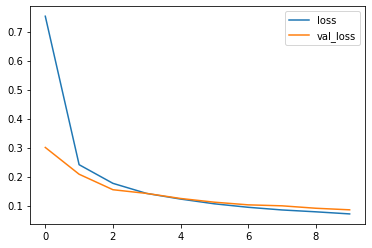

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# **Plotar gráfico da precisão**

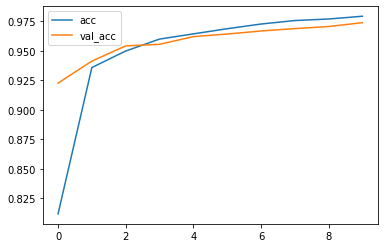

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

Primeiramente, realizamos uma previsão utilizando o modelo, e **utilizamos um loop para percorrer cada uma das camadas da rede neural construída**.

- No caso, são as colunas em "targets" e "predictions".
- Para cada coluna, calculamos a métrica AUC e, ao fim, tomamos o valor médio das 6 métricas obtidas.

Também **poderíamos ter dividido os dados em um conjunto de treino e um conjunto de teste**.

Porém, as funções de perda e precisão não estão discordantes, o que é um indicativo de que não está ocorrendo sobreajuste (overfitting).

# **NOTA: Realizar previsões com o modelo**

Note que o comando `model.predict(X)` calcula os valores previstos pelo modelo `model` para cada um dos valores do dataframe `X` fornecido como input.